# Destilación de conocimiento de una red neuronal

Demostración del método de destilación de conocimiento en datos MNIST

* Entrene un modelo "caro" y grande en datos MNIST para lograr un buen rendimiento de generalización. Este es el modelo del profesor.
* Cree un modelo mucho más económico y más pequeño, pero en lugar de usar las etiquetas reales, use las predicciones del modelo del profesor en los datos de entrenamiento. Estas son las etiquetas suaves y este modelo se llama estudiante
* Compare su rendimiento con el mismo modelo entrenado en etiquetas reales. Resulta que el modelo del estudiante tiene un rendimiento mucho mejor en la generalización de datos de prueba

In [1]:
%load_ext autoreload
%autoreload 2

### Librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold

import utils

### Importación de los datos MNIST

In [3]:
mnist = tf.keras.datasets.mnist

### División de los datos de entrenamiento y prueba

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Los datos del conjunto MNIST se dividen entre 255 porque los valores ed los píxeles en las imágenes de MNIST están en un rango de 0 a 255. Este rango representa la intensidad de cada píxel, donde 0 es completamente negro y 255 es completamente blanco. Al dividir los valores entre 255, se normalizan a un rango entre 0 y 1, lo cual es una práctica común en el preprocesamiento de datos para redes neuronales. Los valores más pequeños tienden a mejorar la eficiencia de los cálculos y evitan problemas con gradientes explosivos o desaparición de gradientes. 

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Agregamos una dimensión extra para el canal de color porque las redes neuronales convolucionales (CNNs), que a menudo se usan con conjuntos de datos de imágenes, requieren que las imágenes tengan una estructura de tres dimensiones: alto, ancho y canales. MNIST solo tiene un canal que es en escala de grises (a diferencia de los colores RGB: rojo,verde y azul). Entonces se agrega una dimensión adicional de tamaño 1 para presentar el canal de color (grises en este caso), de modo que la imagen tenga el formato adecuado para el modelo

In [6]:
# agregamos una dimensión
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

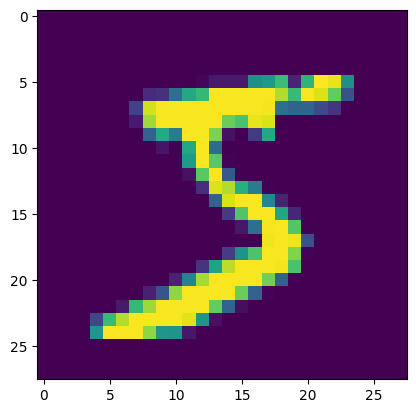

In [7]:
plt.imshow(X_train[0, :, :, 0])

In [8]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_train, num_test

(60000, 10000)

In [9]:
tf.random.set_seed(0)

### Modelo Maestro

Entrene un modelo grande y de alto consumo de recursos que utilice Dropout y que generalice bien los datos de prueba.
Aquí, por "grande" nos referimos a una red neuronal amplia con filtros de convolución y dos capas ocultas completamente conectadas.

In [10]:
class TeacherModel(Model):
    def __init__(self, T: float):
        super(TeacherModel, self).__init__()
        
        self.T = T
        
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        
        self.d1 = Dense(100, activation="relu")
        self.d2 = Dense(100, activation="relu")
        self.d3 = Dense(100, activation="relu")
        self.d4 = Dense(100, activation="relu")
        self.d5 = Dense(10)
        
        self.dropout_layer_hidden = tf.keras.layers.Dropout(rate=0.5)
        
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        
        x = self.d1(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d2(x)
        x = self.dropout_layer_hidden(x)

        x = self.d3(x)
        x = self.dropout_layer_hidden(x)

        x = self.d4(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d5(x)
        x = self.output_layer(x / self.T)
        return x

El Softmax Temperature es una técnica que se utiliza para ajustar la "suavidad" o "confianza" de la distribución de probabilidad producida por la función softmax en modelos de machine learning, como redes neuronales.

En la función softmax estándar, los valores de entrada (también llamados logits) se transforman en probabilidades que suman 1. Al aplicar una temperatura al softmax, se ajusta la distribución de esas probabilidades modificando la forma en que los logits afectan las salidas.

Cómo afecta la temperatura:
* Alta temperatura (T > 1): La salida del softmax será más "suave", lo que significa que las probabilidades estarán más distribuidas y serán más cercanas entre sí. Esto se traduce en menos confianza en las predicciones.
* Baja temperatura (T < 1): La salida del softmax será más "brusca", lo que significa que una clase dominante tendrá una probabilidad mucho mayor y las demás mucho menores. Esto incrementa la confianza en las predicciones.
* Temperatura T = 1: El softmax funciona de manera estándar, sin ningún ajuste adicional.

Aplicaciones comunes:
* Distillation de modelos: En el proceso de Knowledge Distillation, el modelo "teacher" utiliza una temperatura mayor para producir predicciones más suaves que el modelo "student" puede aprender mejor.

En nuestro caso, al entrenar un modelo alumno a partir de un modelo maestro, una temperatura alta suaviza las predicciones del maestro (no enfoncandose en las clases más probables, que podrían estár sobrevaloradas por el maestro), haciendo que el alumno aprenda mejor patrones generales en lugar de enfocarse únicamente en las clases más probables. Es decir, estamos priorizando una salida más balancead, donde las probabilidades de las clases no se concentrarán tanto en una sola opción, sino que estarán más repartidas. 

In [11]:
T = 3.5  # Softmax temperature
teacher = TeacherModel(T=T)

### Entrenamiento del modelo maestro

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

teacher.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [13]:
num_epochs = 3
batch_size = 32

teacher.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.2)

Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8550 - loss: 0.4556 - val_accuracy: 0.9657 - val_loss: 0.1128
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9754 - loss: 0.0794 - val_accuracy: 0.9672 - val_loss: 0.1058
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9865 - loss: 0.0453 - val_accuracy: 0.9769 - val_loss: 0.0814


### Evaluación del modelo maestro

In [14]:
y_pred_teacher = np.argmax(teacher(X_test), axis=1)

In [15]:
acc = accuracy_score(y_test, y_pred_teacher)
acc

0.9779

El modelo de profesor logró 263 errores de prueba.

In [16]:
int((1 - acc) * num_test)

221

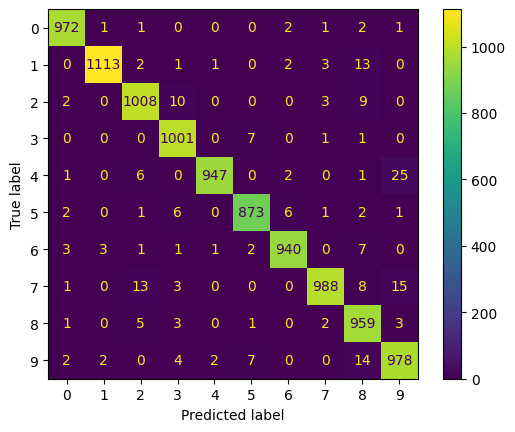

In [17]:
cm = confusion_matrix(y_test, y_pred_teacher)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



### Calcule también las predicciones del profesor sobre el conjunto de entrenamiento.
Estas se utilizarán más adelante para entrenar el modelo del estudiante.


In [18]:
y_train_pred_teacher = teacher(X_train)

### Modelo de estudiante
Se utiliza una red neuronal mucho más pequeña y superficial como modelo de estudiante.

In [19]:
class StudentModel(Model):
    def __init__(self, T):
        super(StudentModel, self).__init__()
        
        self.T = T
        
        self.input_layer = tf.keras.layers.Flatten(input_shape=(28, 28))
        self.d1 = Dense(10, activation="relu")
        self.d2 = Dense(10)
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.input_layer(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.output_layer(x / self.T)
        return x

### Entrenar el modelo pequeño con las etiquetas originales
Primero entrenaremos el modelo pequeño con las etiquetas originales y evaluaremos su rendimiento al generalizarlo con datos de prueba.
Esperamos que su rendimiento sea peor que el del modelo del profesor, ya que tiene muchos menos parámetros


In [34]:
small_model = StudentModel(T=1.0)

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

small_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [36]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    small_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = small_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(y_test_kf, y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
Fold: 1, accuracy: 0.9173
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
Fold: 2, accuracy: 0.9213
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step
Fold: 3, accuracy: 0.92955


In [37]:
scores.mean()

0.9227166666666666

In [38]:
small_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_small = np.argmax(small_model.predict(X_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


In [39]:
acc = accuracy_score(y_test, y_pred_small)
acc

0.9307

El modelo pequeño entrenado con etiquetas originales logró 693 errores de prueba

In [40]:
int((1 - acc)*num_test)

693

### Transformar el conocimiento del modelo del gran profesor en el modelo del pequeño estudiante


In [27]:
student_model = StudentModel(T=1.9)

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

student_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [29]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train_pred_teacher.numpy()[train_index], y_train_pred_teacher.numpy()[test_index]

    student_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = student_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(np.argmax(y_test_kf, axis=1), y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
Fold: 1, accuracy: 0.91985
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Fold: 2, accuracy: 0.92825
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
Fold: 3, accuracy: 0.93265


In [30]:
scores.mean()


0.9269166666666667

In [31]:
student_model.fit(X_train, y_train_pred_teacher, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_student = np.argmax(student_model(X_test), axis=1)

In [32]:
acc = accuracy_score(y_test, y_pred_student)
acc

0.9362

In [33]:
int((1 - acc)*num_test)

637